In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import os
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

from sbi.inference import infer
import sbi.utils as utils
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.half_normal import HalfNormal
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Reference trajectory

In [4]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


In [6]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)


[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]


In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)

(250, 3, 5)


In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


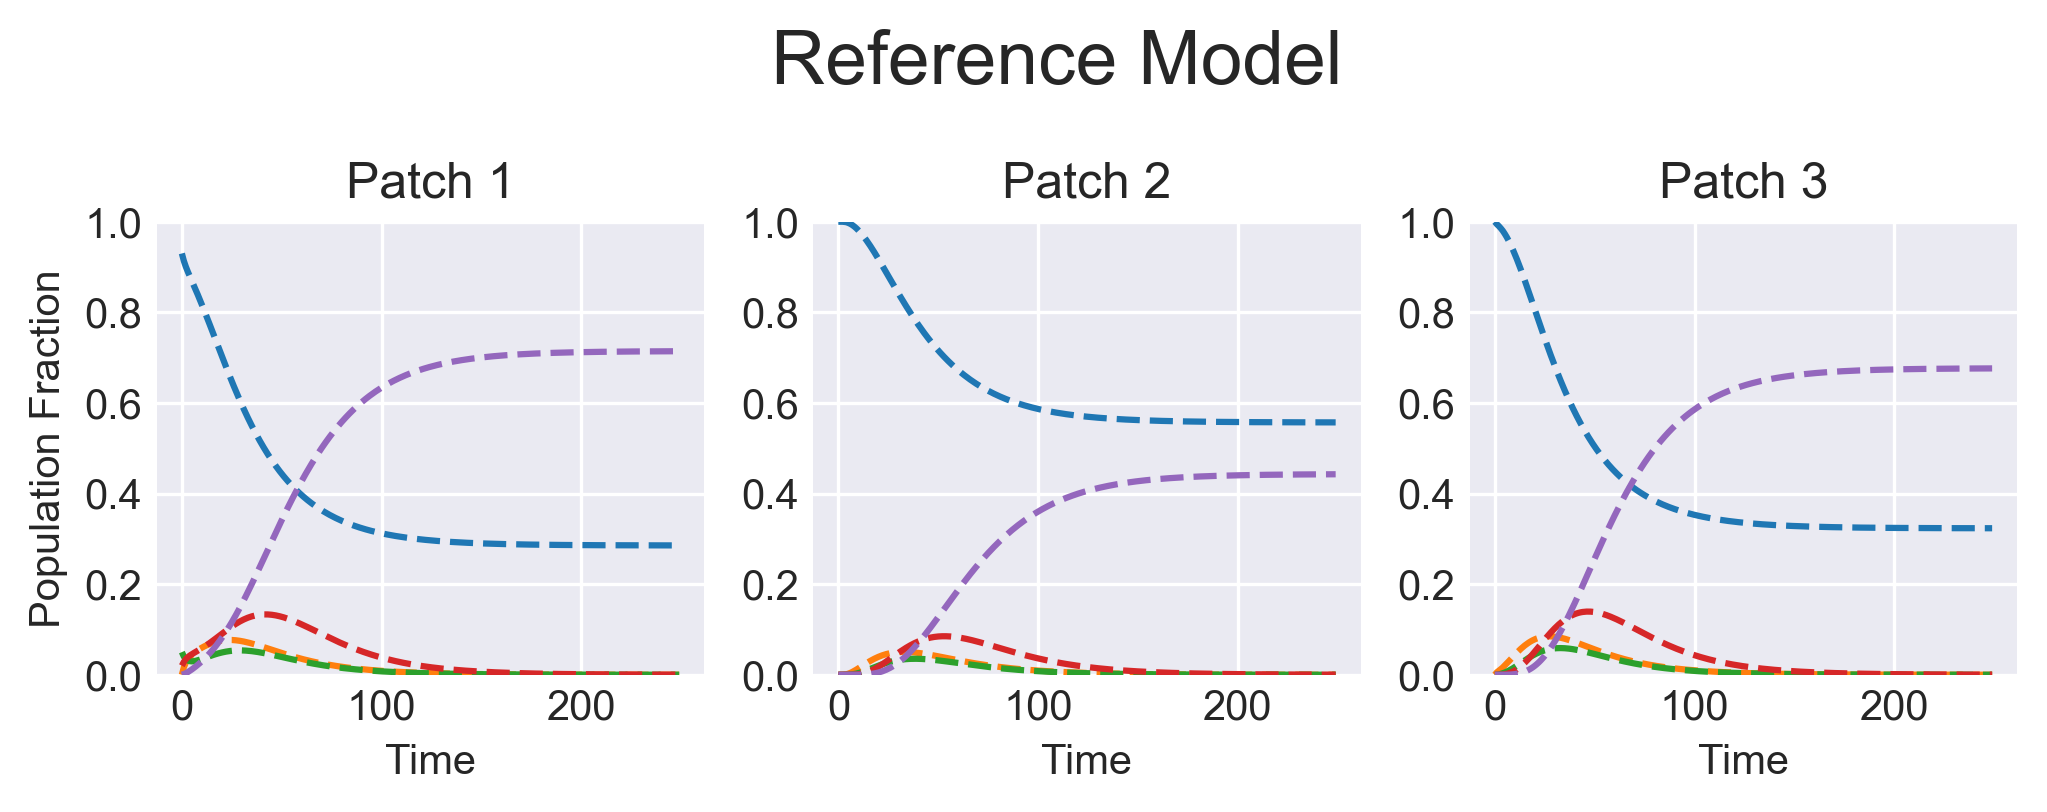

(3, 4)


In [6]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))
print (start.shape)

## Restraints

In [7]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


## sbi

In [8]:
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 2
A_time = 2
I_time = 10


def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    compartments = ['E', 'A', 'I', 'R']
    infections_compartments = [1,2]
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 0)
    tmat.add_transition('A', 'I', A_time, 0)
    tmat.add_transition('I', 'R', I_time, 0)
    infect_fxn_abc = maxentep.contact_infection_func(infections_compartments)
    timesteps = 250
    meta_model = maxentep.MetaModel(infect_fxn_abc, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory

def sbi_model(parameter_list):
    ''' parameter_list oder: start_infected, start_asymptomatic, E_time, A_time, I_time '''
    trajectory = metapop_wraper(float(parameter_list[0]),float(parameter_list[1]), \
                               + float(parameter_list[2]), float(parameter_list[3]), float(parameter_list[4])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values =torch.tensor([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return values

In [20]:
import tensorflow_probability as tfp
prior_means = [start_infected, start_asymptomatic, E_time, A_time, I_time]
# p = HalfNormal(torch.ones(1)*0.001, torch.ones(1)*0.5)
prior =  MultivariateNormal(loc=torch.as_tensor(prior_means),
                                covariance_matrix=torch.as_tensor(torch.eye(5)*torch.tensor([0.5, 0.5, 1, 4, 5])))
print(prior)

MultivariateNormal(loc: torch.Size([5]), covariance_matrix: torch.Size([5, 5]))


In [15]:
posterior = infer(sbi_model, prior, method='SNLE', num_simulations=400)


Neural network successfully converged after 175 epochs. 36 37 38 39 42 43 47 48 53 54 57 60 61 6263 65 66 72 73 75 80 83 84 89 90 91 92 97 98 99 101 102 103 104 105 106 109 125 126


In [16]:

observation_summary_stats =  torch.tensor([r.target for r in restraints])
samples = posterior.sample((2000,),
                                x=observation_summary_stats)

Generating samples: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [23:03<00:00,  1.45it/s]


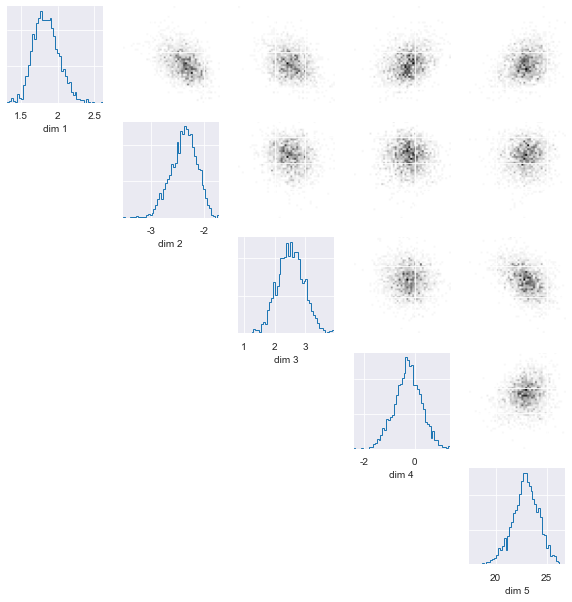

In [19]:
fig, axes = utils.pairplot(samples)
np.savetxt('sbi_samples_new.txt', np.array(samples))

In [83]:
from tqdm import tqdm
sbi_data = np.genfromtxt('sbi_samples_new.txt')
sbi_trajs=np.empty((len(sbi_data), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
for i, sample in enumerate(tqdm(sbi_data)):
    start_infected, start_asymptomatic, E_time, A_time, I_time = sample[0], sample[1], sample[2], sample[3], sample[4]
    traj = metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time)
    sbi_trajs[i] = traj

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [20:31<00:00,  1.62it/s]


In [18]:
print(sbi_trajs.shape)
mean_sbi_traj = np.mean(sbi_trajs, axis = 0)
fig, axs = plt.subplots( figsize=(3.5,3.5), dpi =300)
plt.setp(plt.gca(), xlabel='Time', title='Fit to compartment R in patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
plt.plot(mean_sbi_traj[:,2,4], color= '#35a9d4', label='sbi')
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='ref')
plt.legend(bbox_to_anchor=(0.9,0.9), fontsize=6)
np.save('mean_sbi_traj_new',mean_sbi_traj)
print(mean_sbi_traj[:,2,4])

NameError: name 'sbi_trajs' is not defined

In [ ]:
for i in range(npoints):
    sampled_restraints = [n for n in restraints if n != restraints[i]]
    print (sampled_restraints)
    restrainted_time_values = [59, 45, 31, 80, 17]
    restrainted_time_values.pop(i)
    values = torch.tensor([trajectory[m, 0, 3].numpy()
                                for m in restrainted_time_values])
    print(values)

In [45]:
import pyabc
start_infected = 0.001
start_asymptomatic = 0.001
E_time = 8
A_time = 2
I_time = 15
prior_means_sbi = [start_infected, start_asymptomatic, E_time, A_time, I_time]
def metapop_wraper(input_list):
        start_infected = input_list[0]
        start_asymptomatic = input_list[1]
        E_time = input_list[2]
        A_time = input_list[3]
        I_time = input_list[4]
        beta = 0.025
        start = np.zeros((3, 4))
        start[0, 2] = start_infected
        start[0, 1] = start_asymptomatic
        compartments = ['E', 'A', 'I', 'R']
        infections_compartments = [1, 2]
        tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
        tmat.add_transition('E', 'A', E_time, 0)
        tmat.add_transition('A', 'I', A_time, 0)
        tmat.add_transition('I', 'R', I_time, 0)
        infect_fxn_abc = maxentep.contact_infection_func(infections_compartments)
        timesteps = 250
        meta_model = maxentep.MetaModel(
            infect_fxn_abc, timesteps, populations=population_fraction)
        trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
        return trajectory

In [ ]:
import itertools
for i in range(5):
    print (i)
    b = a[:i+1]
    if len(b)<5:
        b += a[i+1:]

        print(a[:i+1], b)

In [70]:
def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)


abc_param_keys = ['start_infected',
                  'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [start_infected, start_asymptomatic, E_time, A_time, I_time]
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

import time
parameter_list_ref = [0.02, 0.05, 7, 5, 14]
m = 5
abc_param_values = [start_infected, start_asymptomatic, E_time, A_time, I_time]
sbi_runtimes = []
abc_runtimes = []
for i in range(m):  
    print('Initializing SBI for {} parameter(s)'.format(i+1))
    var_list = [0.5, 0.5, 1, 3, 4]
    prior_sbi = MultivariateNormal(loc=torch.as_tensor(prior_means_sbi[:i+1]),
                                   covariance_matrix=torch.as_tensor(torch.eye(i+1)*torch.tensor(var_list[:i+1])))
    def sbi_model(p):
        ''' parameter_list oder: start_infected, start_asymptomatic, E_time, A_time, I_time '''
        p = p.tolist()
        if i ==0:
            p = [p]
        if len(p)<5:
            p += parameter_list_ref[i+1:]
        trajectory = metapop_wraper(p)
        restrainted_time_values = [59, 45, 31, 80, 17]
        values = torch.tensor([trajectory[m, 0, 3].numpy()
                            for m in restrainted_time_values])
        return values
    time_start_sbi = time.clock()
    posterior = infer(sbi_model, prior_sbi,
                      method='SNLE', num_simulations=5)
    observation_sbi = torch.tensor(
        [r.target for r in restraints])
    samples_sbi = posterior.sample((10,),
                                   x=observation_sbi)
    time_elapsed_sbi = time.clock() - time_start_sbi
    sbi_runtimes.append(time_elapsed_sbi)
    
    print('Initializing ABC for {} parameter(s)'.format(i+1))

    
    if i == 0:
        prior_abc = pyabc.Distribution(
            start_infected=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[0], 0.5))
    if i == 1:
            prior_abc = pyabc.Distribution(
                start_infected=pyabc.RV(
                    "truncnorm", 0, 0.5, abc_param_values[0], 0.5),
                start_asymptomatic=pyabc.RV(
                    "truncnorm", 0, 0.5, abc_param_values[1], 0.5))
    if i ==2:
        prior_abc = pyabc.Distribution(
            start_infected=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[0], 0.5),
            start_asymptomatic=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[1], 0.5),
            E_time=pyabc.RV("norm", abc_param_values[2], 1))
    if  i == 3:
        prior_abc = pyabc.Distribution(
            start_infected=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[0], 0.5),
            start_asymptomatic=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[1], 0.5),
            E_time=pyabc.RV("norm", abc_param_values[2], 1),
            A_time=pyabc.RV("norm", abc_param_values[3], 3))
    if  i == 4:
        prior_abc = pyabc.Distribution(
            start_infected=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[0], 0.5),
            start_asymptomatic=pyabc.RV(
                "truncnorm", 0, 0.5, abc_param_values[1], 0.5),
            E_time=pyabc.RV("norm", abc_param_values[2], 1),
            A_time=pyabc.RV("norm", abc_param_values[3], 3),
            I_time=pyabc.RV("norm", abc_param_values[4], 4))
    def abc_model(p):
        p = [p[key] for key in abc_param_keys[:i+1]]
        if len(p) < 5:
            p += parameter_list_ref[i+1:]
        trajectory = metapop_wraper(p)
        restrainted_time_values = [59, 45, 31, 80, 17]
        values = np.array([trajectory[m, 0, 3].numpy()
                        for m in restrainted_time_values])
        return {'data': values}
    

    abc = pyabc.ABCSMC(abc_model, prior_abc, distance)
    db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_SEAIR_param.db')
    observation_abc = np.array([r.target for r in restraints])
    abc.new(db_path, {'data': observation_abc})
    time_start_abc = time.clock()
    history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)
    time_elapsed_abc = time.clock() - time_start_abc
    abc_runtimes.append(time_elapsed_abc)

INFO:History:Start <ABCSMC(id=22, start_time=2020-10-04 01:01:44.512358, end_time=None)>
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\ipykernel_launcher.py:99: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
INFO:ABC:Calibration sample before t=0.


Initializing SBI for 5 parameter(s)
MultivariateNormal(loc: torch.Size([5]), covariance_matrix: torch.Size([5, 5]))
Initializing ABC for 5 parameter(s)
[0.11756712869419243, 0.22723905137185565, 7.492262936275708, 1.7993508610459703, 19.87899941884956]
[0.20096078899919548, 0.20254277627600512, 9.232877184712365, 4.241897705820383, 18.992190702711948]
[0.11518635786087787, 0.2477043020791717, 7.849928900960587, 3.722101057959557, 19.76593960226302]
[0.20592412186603345, 0.029393327286918108, 8.994363233521632, 11.241943035341176, 12.23761449386139]
[0.060890950803928874, 0.08247192568494519, 6.426707068660378, -1.6988512537652127, 18.47119517115948]
[0.07340805201580496, 0.23754318948196604, 9.93458200109787, 2.703617866987815, 12.355642681670211]
[0.12452523203896736, 0.09408280244985227, 8.04078395870378, -0.2758135224119531, 16.83882873061573]
[0.0702364717001772, 0.019320858085470457, 8.147379023263616, 4.994206266296105, 17.711365772299235]
[0.06555025188631415, 0.0984680363930592

KeyboardInterrupt: 